In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings 
warnings.filterwarnings("ignore")
from pydataset import data
import wrangle as wg
pd.set_option('display.max_rows', 100)
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
np.random.seed(77)


In [2]:
df = wg.acquire()


In [3]:
pd.set_option('display.max_columns', None)


In [4]:
def tidy(df):
    # drop redundant id code columns
    id_cols = [col for col in df.columns if 'typeid' in col or col in ['id', 'parcelid']]
    df = df.drop(columns=id_cols)
    # filter for single family properties
    df = df[df.propertylandusedesc == 'Single Family Residential']
    # drop specified columns
    cols_to_drop = ['calculatedbathnbr',
                    'finishedfloor1squarefeet',
                    'finishedsquarefeet12', 
                    'regionidcity',
                    'landtaxvaluedollarcnt',
                    'taxamount',
                    'rawcensustractandblock',
                    'roomcnt',
                    'regionidcounty']
    df = df.drop(columns=cols_to_drop)
    # fill null values with 0 in specified columns
    cols_to_fill_zero = ['fireplacecnt',
                         'garagecarcnt',
                         'garagetotalsqft',
                         'hashottuborspa',
                         'poolcnt',
                         'threequarterbathnbr',
                         'taxdelinquencyflag']
    for col in cols_to_fill_zero:
        df[col] = np.where(df[col].isna(), 0, df[col]) 
    # drop columns with more than 5% null values
    for col in df.columns:
        if df[col].isnull().mean() > .05:
            df = df.drop(columns=col)
    # drop duplicate rows and remaining nulls
    df = df.drop_duplicates()
    df = df.dropna()
    
    return df

In [5]:
df = tidy(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51673 entries, 0 to 52318
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51673 non-null  float64
 1   bedroomcnt                    51673 non-null  float64
 2   calculatedfinishedsquarefeet  51673 non-null  float64
 3   fips                          51673 non-null  float64
 4   fireplacecnt                  51673 non-null  float64
 5   fullbathcnt                   51673 non-null  float64
 6   garagecarcnt                  51673 non-null  float64
 7   garagetotalsqft               51673 non-null  float64
 8   hashottuborspa                51673 non-null  float64
 9   latitude                      51673 non-null  float64
 10  longitude                     51673 non-null  float64
 11  lotsizesquarefeet             51673 non-null  float64
 12  poolcnt                       51673 non-null  float64
 13  p

In [7]:
def optimize(df):
    #Create a dictionary mapping the fips values to the counties
    county_dict = {6037.0: 'LA County', 6059.0: 'Orange County',
                   6111.0: 'Ventura County'}
    #Replace the fips numbers with county names
    df['fips'].replace(county_dict, inplace=True)
    df.rename(columns={'fips': 'county'}, inplace=True)
    # changing numeric codes to strings
    df['regionidzip'] = df.regionidzip.apply(lambda x: str(int(x)))
    df['censustractandblock'] = df.censustractandblock.apply(lambda x: str(int(x)))
    # change the 'Y' in taxdelinquencyflag to 1
    df['bool_taxdelinquencyflag'] = np.where(df.taxdelinquencyflag == 'Y', 1, df.taxdelinquencyflag)
    # change boolean column to int
    df['bool_hot_tub_or_spa'] = df.hashottuborspa.apply(lambda x: str(int(x)))
    # changing year from float to int
    df['yearbuilt'] = df.yearbuilt.apply(lambda x: int(x))
    df['assessment_year'] = df.assessmentyear.apply(lambda x: int(x))
    # moving the latitude and longitude decimal place
    df['latitude'] = df.latitude / 1_000_000
    df['longitude'] = df.longitude / 1_000_000
    # adding a feature: age 
    df['age'] = 2017 - df.yearbuilt
    df = df.drop(columns='yearbuilt')
    # add a feature: has_garage
    df['bool_has_garage'] = np.where(df.garagecarcnt > 0, 1, 0)
    # add a feature: has_pool
    df['bool_has_pool'] = np.where(df.poolcnt > 0, 1, 0)
    # add a feature: has_fireplace
    df['bool_has_fireplace'] = np.where(df.fireplacecnt > 0, 1, 0)
    # add a feature: taxvalue_per_sqft
    df['taxval_sqft'] = df.taxvaluedollarcnt / df.calculatedfinishedsquarefeet
    # rename sqft column
    df = df.rename(columns={'calculatedfinishedsquarefeet': 'sq_ft'})
    # add a column: absolute value of logerror (derived from target)
    df['abs_logerror'] = abs(df.logerror)
    # add a column: direction of logerror (high or low) (derived from target)
    df['logerror_direction'] = np.where(df.logerror < 0, 'low', 'high')
    
    
    return df

In [8]:
df = optimize(df)

In [9]:
df.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,propertycountylandusecode,regionidzip,threequarterbathnbr,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyflag,censustractandblock,logerror,transactiondate,propertylandusedesc,bool_taxdelinquencyflag,bool_hot_tub_or_spa,assessment_year,age,bool_has_garage,bool_has_pool,bool_has_fireplace,taxval_sqft,abs_logerror,logerror_direction
0,3.5,4.0,3100.0,Orange County,0.0,3.0,2.0,633.0,0.0,33.634931,-117.869207,4506.0,0.0,122,96978,1.0,485713.0,1023282.0,2016.0,0,60590630072012,0.025595,2017-01-01,Single Family Residential,0,0,2016,19,1,0,0,330.090968,0.025595,high
1,1.0,2.0,1465.0,Ventura County,1.0,1.0,1.0,0.0,0.0,34.449266,-119.281531,12647.0,0.0,1110,97099,0.0,88000.0,464000.0,2016.0,0,61110010023006,0.055619,2017-01-01,Single Family Residential,0,0,2016,50,1,0,1,316.723549,0.055619,high
2,2.0,3.0,1243.0,Orange County,0.0,2.0,2.0,440.0,0.0,33.886168,-117.823170,8432.0,1.0,122,97078,0.0,85289.0,564778.0,2016.0,0,60590218022012,0.005383,2017-01-01,Single Family Residential,0,0,2016,55,1,1,0,454.366854,0.005383,high
3,3.0,4.0,2376.0,LA County,0.0,3.0,0.0,0.0,0.0,34.245180,-118.240722,13038.0,1.0,0101,96330,0.0,108918.0,145143.0,2016.0,0,60373001001006,-0.103410,2017-01-01,Single Family Residential,0,0,2016,47,0,1,0,61.087121,0.103410,low
4,3.0,4.0,2962.0,LA County,0.0,3.0,0.0,0.0,0.0,34.145202,-118.179824,63000.0,1.0,0101,96293,0.0,276684.0,773303.0,2016.0,0,60374608001014,-0.001011,2017-01-01,Single Family Residential,0,0,2016,67,0,1,0,261.074612,0.001011,low


In [10]:
df.shape

(51673, 34)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51673 entries, 0 to 52318
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroomcnt                 51673 non-null  float64
 1   bedroomcnt                  51673 non-null  float64
 2   sq_ft                       51673 non-null  float64
 3   county                      51673 non-null  object 
 4   fireplacecnt                51673 non-null  float64
 5   fullbathcnt                 51673 non-null  float64
 6   garagecarcnt                51673 non-null  float64
 7   garagetotalsqft             51673 non-null  float64
 8   hashottuborspa              51673 non-null  float64
 9   latitude                    51673 non-null  float64
 10  longitude                   51673 non-null  float64
 11  lotsizesquarefeet           51673 non-null  float64
 12  poolcnt                     51673 non-null  float64
 13  propertycountylandusecode   516

In [12]:
def train_validate_test_split(df):
    '''
    This function takes in a dataframe, then splits that dataframe into three separate samples
    called train, test, and validate, for use in machine learning modeling.
    Three dataframes are returned in the following order: train, test, validate. 
    
    The function also prints the size of each sample.
    '''
    # split the dataframe into train and test
    train, test = train_test_split(df, test_size=.2, random_state=77)
    # further split the train dataframe into train and validate
    train, validate = train_test_split(train, test_size=.3, random_state=77)
    # print the sample size of each resulting dataframe
    print(f'train\t n = {train.shape[0]}')
    print(f'test\t n = {test.shape[0]}')
    print(f'validate n = {validate.shape[0]}')

    return train, validate, test

In [13]:
train, validate, test = train_validate_test_split(df)

train	 n = 28936
test	 n = 10335
validate n = 12402


In [14]:
def remove_outliers(train, validate, test):
    ''' 
    This function takes in a dataset split into three sample dataframes: train, validate and test.
    It calculates an outlier range based on a given value for k, using the interquartile range 
    from the train sample. It then applies that outlier range to each of the three samples, removing
    outliers from a given list of feature columns. The train, validate, and test dataframes 
    are returned, in that order. 
    '''
    #specify outlier columns & target
    target = 'logerror'
    outlier_columns = [col for col in df.columns if ((df[col].dtype != 'object') & (col not in [target, 'latitude', 'longitude']))]
    
    # Create a column that will label our rows as containing an outlier value or not
    train['outlier'] = False
    validate['outlier'] = False
    test['outlier'] = False
    for col in outlier_columns:

        q1, q3 = train[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + 15 * iqr   # get upper bound
        lower_bound = q1 - 15 * iqr   # get lower bound

        # update the outlier label any time that the value is outside of boundaries
        train['outlier'] = np.where(((train[col] < lower_bound) | (train[col] > upper_bound)) & (train.outlier == False), True, train.outlier)
        validate['outlier'] = np.where(((validate[col] < lower_bound) | (validate[col] > upper_bound)) & (validate.outlier == False), True, validate.outlier)
        test['outlier'] = np.where(((test[col] < lower_bound) | (test[col] > upper_bound)) & (test.outlier == False), True, test.outlier)

    # remove observations with the outlier label in each of the three samples
    train = train[train.outlier == False]
    train = train.drop(columns=['outlier'])

    validate = validate[validate.outlier == False]
    validate = validate.drop(columns=['outlier'])

    test = test[test.outlier == False]
    test = test.drop(columns=['outlier'])
    
    # print the remaining 
    print(f'train\t n = {train.shape[0]}')
    print(f'test\t n = {test.shape[0]}')
    print(f'validate n = {validate.shape[0]}')

    return train, validate, test

In [15]:
train, validate, test = remove_outliers(train, validate, test)

train	 n = 17636
test	 n = 6348
validate n = 7529


In [16]:
# k of 1.5
train	 n = 13685
test	 n = 4918
validate n = 5859

SyntaxError: invalid syntax (1880447455.py, line 2)

In [ ]:
df.info()

In [17]:
def MM_scale_zillow(train, validate, test):
    '''
    This takes in the train, validate, and test dataframes, as well as the target label. 
    It then fits a scaler object to the train sample based on the given sample_type, applies that
    scaler to the train, validate, and test samples, and appends the new scaled data to the 
    dataframes as additional columns with the prefix 'scaled_'. 
    train, validate, and test dataframes are returned, in that order. 
    '''
    target = 'logerror'
    
    # identify quantitative features to scale
    quant_features = [col for col in train.columns if (train[col].dtype != 'object') & (col != target)]
    
    # establish empty dataframes for storing scaled dataset
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    # create and fit the scaler
    scaler = MinMaxScaler().fit(train[quant_features])
    
    # adding scaled features to scaled dataframes
    train_scaled[quant_features] = scaler.transform(train[quant_features])
    validate_scaled[quant_features] = scaler.transform(validate[quant_features])
    test_scaled[quant_features] = scaler.transform(test[quant_features])
   

    return train_scaled, validate_scaled, test_scaled

In [18]:
train_scaled, validate_scaled, test_scaled = MM_scale_zillow(train, validate, test)

In [19]:
train_scaled.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,propertycountylandusecode,regionidzip,threequarterbathnbr,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyflag,censustractandblock,logerror,transactiondate,propertylandusedesc,bool_taxdelinquencyflag,bool_hot_tub_or_spa,assessment_year,age,bool_has_garage,bool_has_pool,bool_has_fireplace,taxval_sqft,abs_logerror,logerror_direction
44102,0.111111,0.272727,0.134422,LA County,0.0,0.111111,0.0,0.0,0.0,0.950941,0.681402,0.098443,0.0,0100,97318,0.0,0.039954,0.018590,0.0,0,60379005011017,0.139988,2017-08-10,Single Family Residential,0,0,0.0,0.306569,0.0,0.0,0.0,0.022691,0.154909,high
45170,0.111111,0.272727,0.160338,LA County,0.0,0.111111,0.0,0.0,0.0,0.569025,0.504662,0.146545,0.0,0100,96424,0.0,0.055286,0.028014,0.0,0,60371411022016,-0.211022,2017-08-16,Single Family Residential,0,0,0.0,0.547445,0.0,0.0,0.0,0.029331,0.233516,low
21331,0.222222,0.272727,0.209892,LA County,0.0,0.222222,0.0,0.0,0.0,0.511396,0.529584,0.094538,0.0,0100,96087,0.0,0.035650,0.026914,0.0,0,60377009014010,-0.030684,2017-05-01,Single Family Residential,0,0,0.0,0.627737,0.0,0.0,0.0,0.021541,0.033949,low
51577,0.111111,0.272727,0.164135,LA County,0.0,0.111111,0.0,0.0,0.0,0.475645,0.857790,0.135706,0.0,0100,96505,0.0,0.042399,0.018564,0.0,Y,60374033191026,0.044806,2017-09-14,Single Family Residential,1,0,0.0,0.299270,0.0,0.0,0.0,0.018603,0.049577,high
20083,0.111111,0.363636,0.092842,LA County,0.0,0.111111,0.0,0.0,0.0,0.458827,0.707937,0.090238,0.0,0100,96174,0.0,0.017462,0.009000,0.0,0,60375010011015,0.010990,2017-04-26,Single Family Residential,0,0,0.0,0.474453,0.0,0.0,0.0,0.015142,0.012155,high


In [20]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((17636, 34), (7529, 34), (6348, 34))


# Explore

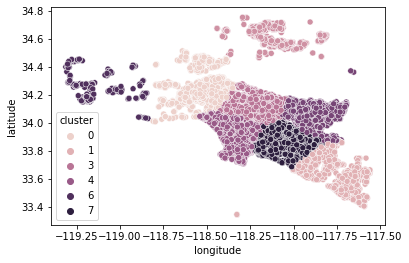

In [27]:
sns.scatterplot(x='longitude', y = 'latitude', data=train, hue='cluster')
plt.show()

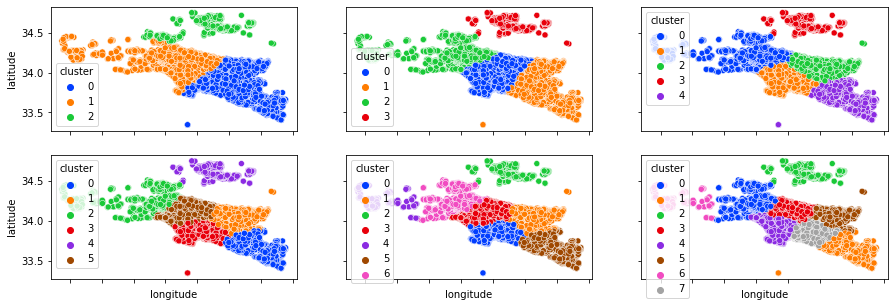

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True, sharex=True)

for i, k in enumerate(range(3,9)):
    
    # creating clusters with KMeans
    x = train_scaled[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=k, random_state=77)
    kmeans.fit(x)
    train['cluster'] = kmeans.predict(x)

    # visualize the clusters
    y = int(i / 3)
    x = i % 3
    ax = sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster',
                         palette='bright', ax=axes[y,x])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [29]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

ValueError: Expected 2D array, got scalar array instead:
array=2.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

<Figure size 648x432 with 0 Axes>